In [206]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [207]:
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
data_path = Path('../data/') 

In [208]:
df = pd.read_pickle(data_path/'logistic_regression_revised_data.pkl')

convert_dict = {'pt': str,
                'axi_avg_prob': np.float64,
                'axi_amount_sick': np.float64,
                'axi_max_prob': np.float64,
                'axi_top10_prob': np.float64,
                'coro_avg_prob': np.float64,
                'coro_amount_sick': np.float64,
                'coro_max_prob': np.float64,
                'coro_top10_prob': np.float64,
                'sagi_avg_prob': np.float64,
                'sagi_amount_sick': np.float64,
                'sagi_max_prob': np.float64,
                'sagi_top10_prob': np.float64,
                'target': np.float64
                }
 
df = df.astype(convert_dict)


train_df = df[df.pt.str.contains('|'.join(['train', 'val']))]
#val_df = df[df.pt.str.contains('|'.join(['val']))]
test_df = df[df.pt.str.contains('|'.join(['test']))]

df


,pt,axi_avg_prob,axi_amount_sick,axi_max_prob,axi_top10_prob,coro_avg_prob,coro_amount_sick,coro_max_prob,coro_top10_prob,sagi_avg_prob,sagi_amount_sick,sagi_max_prob,sagi_top10_prob,target
0,../../data/nii/anonymized/train/Cmet0387,0.325702,41.0,1.000000,0.999998,0.340606,44.0,1.000000,0.999999,0.312082,38.0,1.000000,0.999998,1.0
1,../../data/nii/anonymized/train/Cmet0091,0.149193,16.0,1.000000,0.972873,0.240060,27.0,1.000000,0.980599,0.181529,15.0,1.000000,0.984075,1.0
2,../../data/nii/anonymized/train/Cmet0445,0.078220,5.0,0.999999,0.559113,0.103455,7.0,0.999994,0.533103,0.067490,4.0,0.999995,0.492262,1.0
3,../../data/nii/anonymized/train/Cmet0943,0.357013,55.0,0.999494,0.940916,0.315725,43.0,0.999973,0.987175,0.402764,63.0,0.999904,0.995224,1.0
4,../../data/nii/anonymized/train/Cmet0503,0.240813,28.0,0.999999,0.968172,0.360418,51.0,0.999995,0.999438,0.359580,46.0,0.999965,0.999020,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,../../data/nii/controls/test/Cmet1331,0.038457,0.0,0.402807,0.249345,0.093851,2.0,0.752204,0.375721,0.026227,0.0,0.297582,0.183674,0.0
1641,../../data/nii/controls/test/Cmet0723,0.062884,5.0,0.745774,0.423417,0.081257,4.0,0.583483,0.431164,0.120932,5.0,0.907085,0.528695,0.0
1642,../../data/nii/controls/test/Cmet0580,0.061756,6.0,0.718902,0.445250,0.019950,0.0,0.320607,0.185221,0.039377,1.0,0.650462,0.304461,0.0
1643,../../data/nii/controls/test/Cmet0412,0.163751,18.0,0.752812,0.696326,0.208948,25.0,0.956795,0.813890,0.138068,11.0,0.829878,0.619289,0.0


In [209]:
train_count = train_df['target'].value_counts()
print('Distribution of train patients: \n\n', train_count)
print('Share of sick patients: ', train_count[1]/train_count[0])

print('\n\n')

test_count = test_df['target'].value_counts()
print('Distribution of test patients: \n\n', test_count)
print('Share of sick patients: ', test_count[1]/test_count[0])

Distribution of train patients: 

 0.0    1251
1.0     147
Name: target, dtype: int64
Share of sick patients:  0.11750599520383694



Distribution of test patients: 

 0.0    221
1.0     26
Name: target, dtype: int64
Share of sick patients:  0.11764705882352941


In [210]:
train_data = train_df[['axi_avg_prob',
                'axi_amount_sick',
                'axi_max_prob',
                'axi_top10_prob',
                'coro_avg_prob',
                'coro_amount_sick',
                'coro_max_prob',
                'coro_top10_prob',
                'sagi_avg_prob',
                'sagi_amount_sick',
                'sagi_max_prob',
                'sagi_top10_prob',
                'target']].to_numpy()


X_train = train_data[:,0:12]
y_train = train_data[:,12]

test_data = test_df[['axi_avg_prob',
                'axi_amount_sick',
                'axi_max_prob',
                'axi_top10_prob',
                'coro_avg_prob',
                'coro_amount_sick',
                'coro_max_prob',
                'coro_top10_prob',
                'sagi_avg_prob',
                'sagi_amount_sick',
                'sagi_max_prob',
                'sagi_top10_prob',
                'target']].to_numpy()

X_test = test_data[:,0:12]
y_test = test_data[:,12]

In [211]:
print(X_train.shape)

(1398, 12)


Logistic regression

In [212]:
log_reg = LogisticRegression(random_state=0, max_iter=1000)
log_reg.fit(X_train, y_train)
print('score log reg: ', log_reg.score(X_test, y_test))
y_pred_log = log_reg.predict(X_test)
y_pred_prob_log = log_reg.predict_proba(X_test)[:,1]
fpr_log, tpr_log, thresholds = roc_curve(y_test, y_pred_prob_log)


score log reg:  0.9311740890688259


Random Forest

In [213]:

best_score = 0.0
best_params = [None, None, None]

for max_feauture in ['sqrt', 'log2', None]:
    for max_depth in [2, 5, 10, None]:
        for n_estimators in [50, 100, 200]:            
            rf = RandomForestClassifier(max_features=max_feauture, max_depth=max_depth, n_estimators=n_estimators)
            cv_scores = cross_val_score(rf, X_train, y_train)
            
            if np.mean(cv_scores) > best_score:
                best_score = np.mean(cv_scores)
                best_params[0]=max_feauture 
                best_params[1]=max_depth
                best_params[2]=n_estimators
            
print(f'best validation score: {best_score}, params: {best_params}')            

rf_optimal = RandomForestClassifier(max_features=best_params[0], 
                                    max_depth=best_params[1], 
                                    n_estimators=best_params[2])
rf_optimal.fit(X_train, y_train)
y_pred_rf = rf_optimal.predict(X_test)
y_pred_prob_rf = rf_optimal.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)
print('score rf: ', rf_optimal.score(X_test, y_test))

best validation score: 0.9649359959037378, params: ['sqrt', 5, 200]
score rf:  0.9271255060728745


In [214]:
#deafult parameters
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('score rf: ', rf.score(X_test, y_test))

score rf:  0.9230769230769231


KNN

In [215]:
#normalize train data
norm_X_train = (X_train- X_train.mean(axis=0)) / X_train.std(axis=0)

#normalize test data
norm_X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0) 

Parameter tuning

In [216]:
best_score = 0.0
best_param = -1

for neigbors in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=neigbors)
    cv_scores = cross_val_score(knn, norm_X_train, y_train)
    
    if np.mean(cv_scores) > best_score:
        best_score = np.mean(cv_scores)
        best_param = neigbors 
        
print(f'best validation score: {best_score}, params: {best_param}')            

knn_optimal = KNeighborsClassifier(n_neighbors=best_param)
knn_optimal.fit(norm_X_train, y_train)
y_pred_knn = knn_optimal.predict(norm_X_test)
y_pred_prob_knn = knn_optimal.predict_proba(norm_X_test)[:,1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_prob_knn)
print('score knn: ', knn_optimal.score(norm_X_test, y_test))

best validation score: 0.9606502816180236, params: 5
score knn:  0.9190283400809717


XG boost

In [217]:
best_score = 0.0
best_params = [None, None, None, None]


for eval_matric in ['logloss']:
    for lr in [0.01, 0.1, 1.0]:
        for max_depth in [2, 5, 10, 20, 50, None]:
            for n_estimators in [2, 5, 10, 50, 100, 200]:            
                xgb = XGBClassifier(eval_metric = eval_matric, learning_rate=lr,  max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic')
                cv_scores = cross_val_score(xgb, X_train, y_train)
                
                if np.mean(cv_scores) > best_score:
                    best_score = np.mean(cv_scores)
                    best_params[0]=eval_matric
                    best_params[1]=lr 
                    best_params[2]=max_depth
                    best_params[3]=n_estimators
            
print(f'best validation score: {best_score}, params: {best_params}')            

xgb_optimal = XGBClassifier(eval_matric=best_params[0], 
                            learning_rate=best_params[1], 
                            max_depth=best_params[2], 
                            n_estimators=best_params[3])

xgb_optimal.fit(X_train, y_train)
y_pred_xgb = xgb_optimal.predict(X_test)
y_pred_prob_xgb = xgb_optimal.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_pred_prob_xgb)
print('score xgb: ', xgb_optimal.score(X_test, y_test))


best validation score: 0.9656554019457244, params: ['logloss', 1.0, 20, 50]
[18:06:12] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_matric" } are not used.

score xgb:  0.9109311740890689


Performance and visualization




AUC log reg 0.7850678733031674
AUC rf 0.7760180995475113
AUC knn 0.7433867037939437
AUC xgb  0.7423424991298294


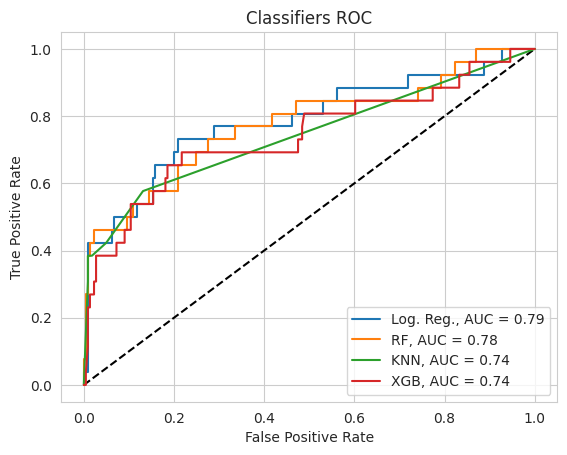

In [218]:
print('\n\n')

print('AUC log reg', roc_auc_score(y_test, y_pred_prob_log))
print('AUC rf', roc_auc_score(y_test, y_pred_prob_rf))
print('AUC knn', roc_auc_score(y_test, y_pred_prob_knn))
print('AUC xgb ', roc_auc_score(y_test, y_pred_prob_xgb))

sns.set_style("whitegrid")

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_log, tpr_log, label=f'Log. Reg., AUC = {roc_auc_score(y_test, y_pred_prob_log):.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF, AUC = {roc_auc_score(y_test, y_pred_prob_rf):.2f}')
plt.plot(fpr_knn, tpr_knn, label=f'KNN, AUC = {roc_auc_score(y_test, y_pred_prob_knn):.2f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB, AUC = {roc_auc_score(y_test, y_pred_prob_xgb):.2f}')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifiers ROC')
plt.show()

In [219]:
print(f"Clasification Report log reg\n\n{classification_report(y_test, y_pred_log)}")
print(f"Clasification Report rf\n\n{classification_report(y_test, y_pred_rf)}")
print(f"Clasification Report knn\n\n{classification_report(y_test, y_pred_knn)}")
print(f"Clasification Report xgb\n\n{classification_report(y_test, y_pred_xgb)}")

Clasification Report log reg

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       221
         1.0       0.85      0.42      0.56        26

    accuracy                           0.93       247
   macro avg       0.89      0.71      0.76       247
weighted avg       0.93      0.93      0.92       247

Clasification Report rf

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       221
         1.0       0.83      0.38      0.53        26

    accuracy                           0.93       247
   macro avg       0.88      0.69      0.74       247
weighted avg       0.92      0.93      0.91       247

Clasification Report knn

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       221
         1.0       0.71      0.38      0.50        26

    accuracy                           0.92       247
   macro avg       0.82      0.68      0.73    

In [220]:
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

alpha = 0.05
y_baseline_prediction = np.zeros(len(y_pred_log))
#Logistic
table_log = mcnemar_table(y_target=y_test,
                   y_model1=y_baseline_prediction,
                   y_model2=y_pred_log)

table_rf = mcnemar_table(y_target=y_test,
                   y_model1=y_baseline_prediction,
                   y_model2=y_pred_rf)

table_knn = mcnemar_table(y_target=y_test,
                   y_model1=y_baseline_prediction,
                   y_model2=y_pred_knn)

table_xgb = mcnemar_table(y_target=y_test,
                   y_model1=y_baseline_prediction,
                   y_model2=y_pred_xgb)


chi2_log, p_log = mcnemar(ary=table_log, corrected=True)
chi2_rf, p_rf = mcnemar(ary=table_rf, corrected=True)
chi2_knn, p_knn = mcnemar(ary=table_knn, corrected=True)
chi2_xgb, p_xgb = mcnemar(ary=table_xgb, corrected=True)

print("p-value of log test", p_log, "   chi-squared value: ", chi2_log)
print("p-value of RF test", p_rf, "   chi-squared value: ", chi2_rf)
print("p-value of KNN test", p_knn, "   chi-squared value: ", chi2_knn)
print("p-value of XGB test", p_xgb, "   chi-squared value: ", chi2_xgb)

p-value of log test 0.026500280602491884    chi-squared value:  4.923076923076923
p-value of RF test 0.04330814281079206    chi-squared value:  4.083333333333333
p-value of KNN test 0.18144920772141646    chi-squared value:  1.7857142857142858
p-value of XGB test 0.2888443663464818    chi-squared value:  1.125


In [221]:
print('positive prediction rate', np.sum(y_pred_log)/len(y_pred_log))
print('ammount classified as abnormal in dataset', (1657/100)*5.2631)
print('precision, how many are actuallly abnormal', (87/100)*85)
print('recall, how many are caught', 74/185)
print(185/100*40)

positive prediction rate 0.05263157894736842
ammount classified as abnormal in dataset 87.20956699999999
precision, how many are actuallly abnormal 73.95
recall, how many are caught 0.4
74.0


In [222]:
(86/100)*85

73.1

In [223]:
86/100*85/86

0.85

Logistic regression plots

<Axes: xlabel='axi_top10_prob', ylabel='target'>

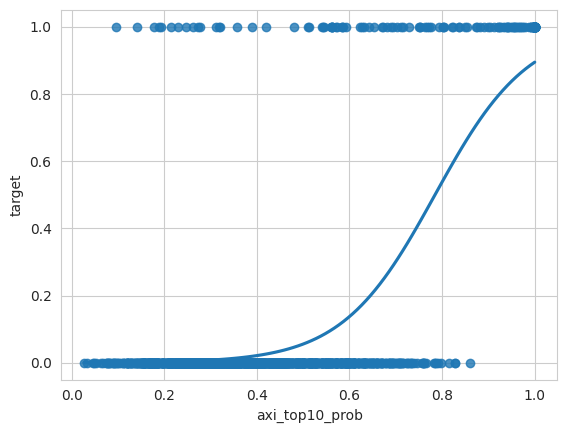

In [224]:
x = train_df['axi_top10_prob']
y = train_df['target']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=train_df, logistic=True, ci=None)

<Axes: xlabel='axi_avg_prob', ylabel='target'>

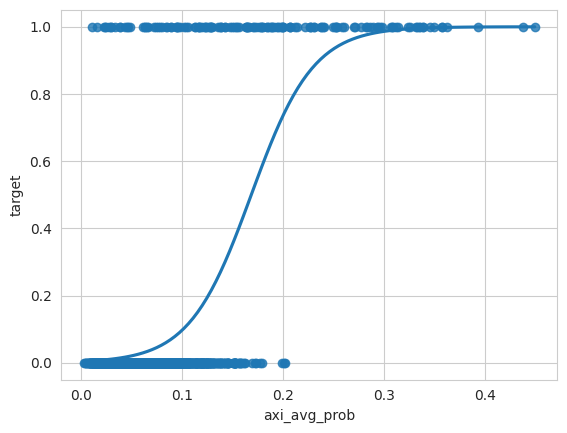

In [225]:
x = train_df['axi_avg_prob']
y = train_df['target']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=train_df, logistic=True, ci=None)

Find sick patients with only class 0 and 1 

In [226]:
df_rtss = pd.read_pickle(data_path/'registered_reference_markings_revised.pkl')
sorted = df_rtss.sort_values(by='ID')

,ID,world_x,world_y,world_z,voxel_x,voxel_y,voxel_z,classificaton,diameter_in_cm,linked_to
255,Cmet0002,-20.672683,170.393776,1215.500,213.163444,201.240215,25.7500,2,3,PT
484,Cmet0013,50.819446,163.367490,-158.500,177.374381,199.450349,48.2500,0,2,PT
265,Cmet0014,9.921610,226.076408,1280.000,197.866297,169.648899,22.7500,2,1,PT
264,Cmet0014,50.873700,323.807483,1298.000,177.390252,120.783362,31.7500,2,5,PT
263,Cmet0014,33.859789,271.149592,1322.000,185.897208,147.112307,43.7500,2,1,PT
262,Cmet0014,67.355638,320.048595,1319.000,169.149284,122.662806,42.2500,2,3,PT
261,Cmet0014,58.984984,320.048595,1340.000,173.334611,122.662806,52.7500,2,5,PT
260,Cmet0014,-4.916103,241.111958,1364.000,205.285154,162.131124,64.7500,2,1,PT
259,Cmet0014,-2.542069,256.938852,1373.000,204.098137,154.217677,69.2500,2,1,PT
267,Cmet0014,53.445571,260.499904,1295.000,176.104317,152.437151,30.2500,2,1,PT


In [227]:
df_rtss.ID.unique().size

177

In [228]:
ds1 = set(df_rtss.ID.unique())
ds2 = set(df_rtss.loc[df_rtss['classificaton'] == '2'].ID.unique())
print(len(ds2))

134


In [229]:
print("Abnormal scans without class 2 metastasis", len(ds1.difference(ds2)))

Abnormal scans without class 2 metastasis 43


Data analysis and overview

In [231]:
train_df = df[df.pt.str.contains('|'.join(['train']))]
val_df = df[df.pt.str.contains('|'.join(['val']))]
test_df = df[df.pt.str.contains('|'.join(['test']))]

In [232]:
train_count = train_df['target'].value_counts()
print('Distribution of train patients: \n\n', train_count)
print('Share of sick patients: ', train_count[1]/train_count[0])

print('\n\n')

val_count = val_df['target'].value_counts()
print('Distribution of test patients: \n\n', val_count)
print('Share of sick patients: ', val_count[1]/val_count[0])

print('\n\n')

test_count = test_df['target'].value_counts()
print('Distribution of test patients: \n\n', test_count)
print('Share of sick patients: ', test_count[1]/test_count[0])

Distribution of train patients: 

 0.0    1000
1.0     117
Name: target, dtype: int64
Share of sick patients:  0.117



Distribution of test patients: 

 0.0    251
1.0     30
Name: target, dtype: int64
Share of sick patients:  0.11952191235059761



Distribution of test patients: 

 0.0    221
1.0     26
Name: target, dtype: int64
Share of sick patients:  0.11764705882352941


Revised Experiments

In [233]:
df_revised = df.copy(deep=True)

lst =  list(ds1.difference(ds2))
print(lst)

['Cmet0032', 'Cmet0034', 'Cmet1041', 'Cmet0657', 'Cmet1181', 'Cmet1195', 'Cmet0599', 'Cmet0272', 'Cmet0537', 'Cmet0621', 'Cmet0539', 'Cmet1607', 'Cmet0212', 'Cmet0598', 'Cmet0523', 'Cmet1082', 'Cmet1193', 'Cmet1588', 'Cmet1310', 'Cmet0498', 'Cmet0931', 'Cmet1687', 'Cmet1167', 'Cmet1225', 'Cmet0214', 'Cmet0568', 'Cmet0547', 'Cmet1137', 'Cmet0258', 'Cmet0059', 'Cmet0666', 'Cmet0991', 'Cmet0693', 'Cmet0968', 'Cmet0562', 'Cmet1316', 'Cmet0911', 'Cmet0343', 'Cmet0442', 'Cmet0013', 'Cmet0172', 'Cmet0970', 'Cmet1078']


Split to train and test

In [234]:
train_df = df_revised[df_revised.pt.str.contains('|'.join(['train', 'val']))]
test_df = df_revised[df_revised.pt.str.contains('|'.join(['test']))]

Change target to 0 for patients with only class 0 and 1 metastases

In [235]:
def string_function(pt_name):
    return pt_name[-8:]

train_df['pt'] = train_df['pt'].apply(lambda x: string_function(x))
test_df['pt'] = test_df['pt'].apply(lambda x: string_function(x))


In [236]:
train_df.loc[train_df['pt'].isin(lst), 'target'] = 0.0
test_df.loc[test_df['pt'].isin(lst), 'target'] = 0.0

Testing of different models

In [237]:
train_data = train_df[['axi_avg_prob',
                'axi_amount_sick',
                'axi_max_prob',
                'axi_top10_prob',
                'coro_avg_prob',
                'coro_amount_sick',
                'coro_max_prob',
                'coro_top10_prob',
                'sagi_avg_prob',
                'sagi_amount_sick',
                'sagi_max_prob',
                'sagi_top10_prob',
                'target']].to_numpy()


X_train = train_data[:,0:12]
y_train = train_data[:,12]

test_data = test_df[['axi_avg_prob',
                'axi_amount_sick',
                'axi_max_prob',
                'axi_top10_prob',
                'coro_avg_prob',
                'coro_amount_sick',
                'coro_max_prob',
                'coro_top10_prob',
                'sagi_avg_prob',
                'sagi_amount_sick',
                'sagi_max_prob',
                'sagi_top10_prob',
                'target']].to_numpy()

X_test = test_data[:,0:12]
y_test = test_data[:,12]
print(X_train.shape)

#Logistic regression

log_reg = LogisticRegression(random_state=0, max_iter=1000)
log_reg.fit(X_train, y_train)
print('score log reg: ', log_reg.score(X_test, y_test))
y_pred_log = log_reg.predict(X_test)
y_pred_prob_log = log_reg.predict_proba(X_test)[:,1]
fpr_log, tpr_log, thresholds = roc_curve(y_test, y_pred_prob_log)

#Random Forest

best_score = 0.0
best_params = [None, None, None]

for max_feauture in ['sqrt', 'log2', None]:
    for max_depth in [2, 5, 10, None]:
        for n_estimators in [50, 100, 200]:            
            rf = RandomForestClassifier(max_features=max_feauture, max_depth=max_depth, n_estimators=n_estimators)
            cv_scores = cross_val_score(rf, X_train, y_train)
            
            if np.mean(cv_scores) > best_score:
                best_score = np.mean(cv_scores)
                best_params[0]=max_feauture 
                best_params[1]=max_depth
                best_params[2]=n_estimators
            
print(f'best validation score: {best_score}, params: {best_params}')            

rf_optimal = RandomForestClassifier(max_features=best_params[0], 
                                    max_depth=best_params[1], 
                                    n_estimators=best_params[2])
rf_optimal.fit(X_train, y_train)
y_pred_rf = rf_optimal.predict(X_test)
y_pred_prob_rf = rf_optimal.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)
print('score rf: ', rf_optimal.score(X_test, y_test))
#deafult parameters
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('score rf: ', rf.score(X_test, y_test))
#normalize train data
norm_X_train = (X_train- X_train.mean(axis=0)) / X_train.std(axis=0)

#normalize test data
norm_X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0) 
best_score = 0.0
best_param = -1

for neigbors in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=neigbors)
    cv_scores = cross_val_score(knn, norm_X_train, y_train)
    
    if np.mean(cv_scores) > best_score:
        best_score = np.mean(cv_scores)
        best_param = neigbors 
        
print(f'best validation score: {best_score}, params: {best_param}')            

knn_optimal = KNeighborsClassifier(n_neighbors=best_param)
knn_optimal.fit(norm_X_train, y_train)
y_pred_knn = knn_optimal.predict(norm_X_test)
y_pred_prob_knn = knn_optimal.predict_proba(norm_X_test)[:,1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_prob_knn)
print('score knn: ', knn_optimal.score(norm_X_test, y_test))
best_score = 0.0
best_params = [None, None, None, None]


for eval_matric in ['logloss']:
    for lr in [0.01, 0.1, 1.0]:
        for max_depth in [2, 5, 10, 20, 50, None]:
            for n_estimators in [2, 5, 10, 50, 100, 200]:            
                xgb = XGBClassifier(eval_metric = eval_matric, learning_rate=lr,  max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic')
                cv_scores = cross_val_score(xgb, X_train, y_train)
                
                if np.mean(cv_scores) > best_score:
                    best_score = np.mean(cv_scores)
                    best_params[0]=eval_matric
                    best_params[1]=lr 
                    best_params[2]=max_depth
                    best_params[3]=n_estimators
            
print(f'best validation score: {best_score}, params: {best_params}')            

xgb_optimal = XGBClassifier(eval_matric=best_params[0], 
                            learning_rate=best_params[1], 
                            max_depth=best_params[2], 
                            n_estimators=best_params[3])

xgb_optimal.fit(X_train, y_train)
y_pred_xgb = xgb_optimal.predict(X_test)
y_pred_prob_xgb = xgb_optimal.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_pred_prob_xgb)
print('score xgb: ', xgb_optimal.score(X_test, y_test))

print('\n\n')




(1398, 12)
score log reg:  0.9352226720647774
best validation score: 0.9813876088069637, params: ['log2', 2, 50]
score rf:  0.9392712550607287
score rf:  0.9473684210526315
best validation score: 0.977811059907834, params: 3
score knn:  0.9392712550607287
best validation score: 0.9820993343573988, params: ['logloss', 0.1, 10, 200]
[18:07:57] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_matric" } are not used.

score xgb:  0.9433198380566802





AUC log reg 0.8024007386888272
AUC rf 0.8037857802400739
AUC knn 0.7493074792243767
AUC xgb  0.7460757156048015


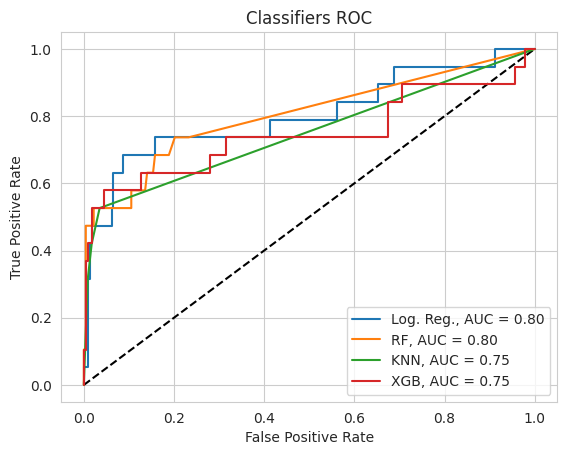

Clasification Report log reg

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       228
         1.0       0.67      0.32      0.43        19

    accuracy                           0.94       247
   macro avg       0.81      0.65      0.70       247
weighted avg       0.92      0.94      0.92       247

Clasification Report rf

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       228
         1.0       0.83      0.26      0.40        19

    accuracy                           0.94       247
   macro avg       0.89      0.63      0.68       247
weighted avg       0.93      0.94      0.92       247

Clasification Report knn

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       228
         1.0       0.67      0.42      0.52        19

    accuracy                           0.94       247
   macro avg       0.81      0.70      0.74    

In [238]:
print('AUC log reg', roc_auc_score(y_test, y_pred_prob_log))
print('AUC rf', roc_auc_score(y_test, y_pred_prob_rf))
print('AUC knn', roc_auc_score(y_test, y_pred_prob_knn))
print('AUC xgb ', roc_auc_score(y_test, y_pred_prob_xgb))

sns.set_style("whitegrid")

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_log, tpr_log, label=f'Log. Reg., AUC = {roc_auc_score(y_test, y_pred_prob_log):.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF, AUC = {roc_auc_score(y_test, y_pred_prob_rf):.2f}')
plt.plot(fpr_knn, tpr_knn, label=f'KNN, AUC = {roc_auc_score(y_test, y_pred_prob_knn):.2f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB, AUC = {roc_auc_score(y_test, y_pred_prob_xgb):.2f}')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifiers ROC')
plt.show()
print(f"Clasification Report log reg\n\n{classification_report(y_test, y_pred_log)}")
print(f"Clasification Report rf\n\n{classification_report(y_test, y_pred_rf)}")
print(f"Clasification Report knn\n\n{classification_report(y_test, y_pred_knn)}")
print(f"Clasification Report xgb\n\n{classification_report(y_test, y_pred_xgb)}")